P5 VEHICLE DETECTION AND TRACKING (NEURAL NETWORK CLASSIFIER)

In [1]:
import numpy as np
import cv2
import glob
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
import scipy.misc
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import scipy.misc




1. CAMERA CALIBRERING

In [2]:
objp = np.zeros((5*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        print('Camera calibration...')
print('Done')


Camera calibration...
Done


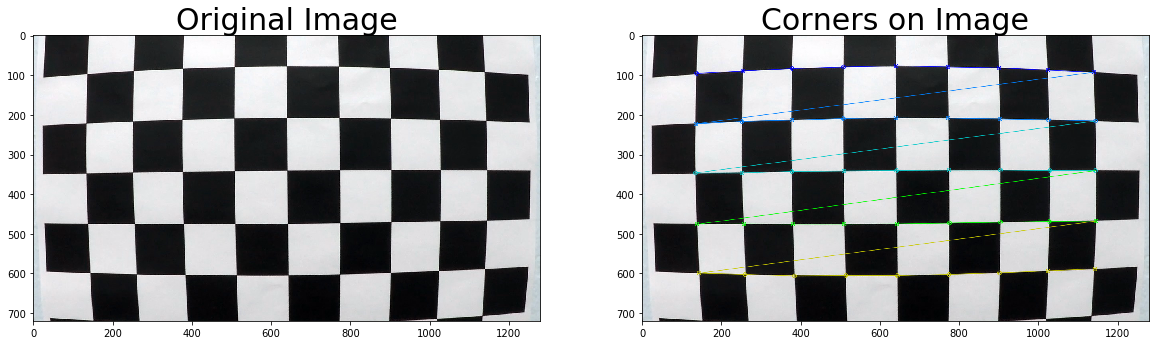

In [3]:
img_chess = cv2.imread('camera_cal/calibration1.jpg')
img_chess_org = cv2.imread('camera_cal/calibration1.jpg')
gray_chess = cv2.cvtColor(img_chess, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray_chess, (9,5), None)
cv2.drawChessboardCorners(img_chess, (9,5), corners, ret)
#plt.figure(figsize=(8,6))
#plt.imshow(img_chess)
#plt.show()
f, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_chess_org)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_chess)
ax2.set_title('Corners on Image', fontsize=30)
plt.show()

In [4]:
def undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

2.TEST ON DISTORTED IMAGE

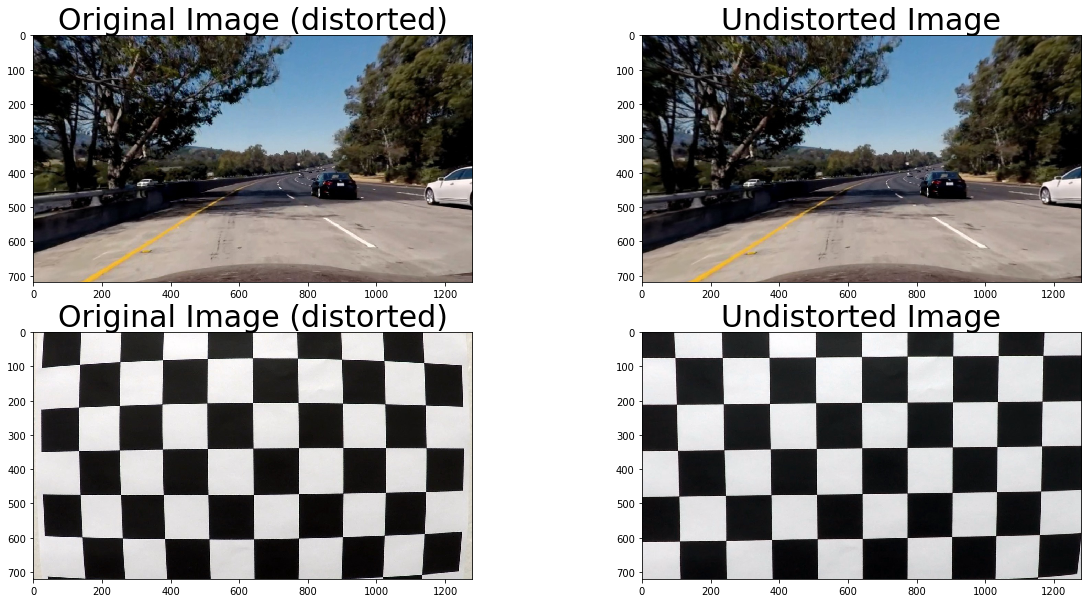

In [5]:
# Test undistortion on an image
img1 = cv2.imread('test_images/test5.jpg')
img_chess = cv2.imread('camera_cal/calibration1.jpg')

img1_size = (img1.shape[1], img1.shape[0])
img_chess_size = (img_chess.shape[1], img_chess.shape[0])
#cv2.imshow('img', img)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img1_size,None,None)


dst1 = cv2.undistort(img1, mtx, dist, None, mtx)
dst2 = cv2.undistort(img_chess, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open( "test_images/wide_dist_pickle.p", "wb" ) )
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_chess = cv2.cvtColor(img_chess, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(img1)
ax1.set_title('Original Image (distorted)', fontsize=30)
dst1 = cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB)
ax2.imshow(dst1)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(img_chess)
ax3.set_title('Original Image (distorted)', fontsize=30)
ax4.imshow(dst2)
ax4.set_title('Undistorted Image', fontsize=30)


3.PERSPECTIVE TRANSFORMATION 

In [6]:
def transform_perspective(img, inverse = False):
    img_size = (img.shape[1], img.shape[0])
    #image_width = image.shape[1]
    #image_height = image.shape[0]
    
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
            
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
        
    if (inverse):
        src, dst = dst, src
        
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    #print ('src', src)
    #print ('dst', dst)
    
    return warped





4.TRANSFORMATION TEST

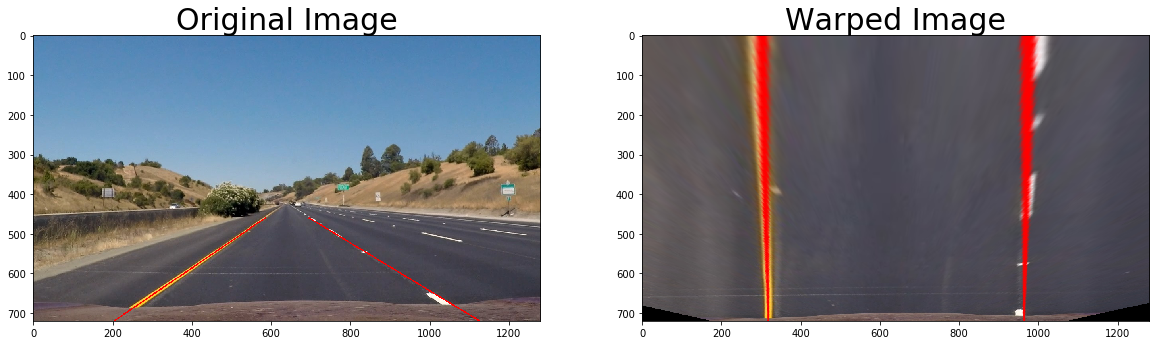

In [7]:
test_img3 = mpimg.imread('test_images/straight_lines1.jpg')


# Let's draw lines on source coordinates to visually confirm they are parallel in the destination image
cv2.line(test_img3, \
         (585, 460), \
         (203, 720), \
         (255, 0, 0), 2)
cv2.line(test_img3, \
         (1126, 720), \
         (695, 460), \
         (255, 0, 0), 2)

undistorted_image = cv2.undistort(test_img3, mtx, dist, None, mtx)
#undistorted_img = undistort(test_img3, mtx, dist)
warped = transform_perspective(undistorted_image)

# Visualize undistortion
f, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img3)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

5.THRESHOLD BINARY IMAGE

In [8]:
def thresholded_binary_image(img):
    s_thresh=(80, 255)
    b_thresh=(95, 255)
    sobel_kernel=3
    
    ############# SOBEL
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel operator calculation for x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Compute the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= s_thresh[0]) & (gradmag <= s_thresh[1])] = 1
    sxbinary=binary_output
    
    #plt.figure(figsize=(24,9))
    #plt.subplot(1, 2, 1)

    #plt.imshow(img)

    #plt.title('Original Image', fontsize=30)
    #plt.subplot(1, 2, 2)
    #plt.title('Gradient direction (Sobel)', fontsize=30)
    #plt.imshow(sxbinary, cmap='gray')
    
    
    ################################# BINARY
    # Apply color threshold
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= b_thresh[0]) & (s_channel <= b_thresh[1])] = 1
 
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1

    return combined_binary

6.TEST THRESHOLD

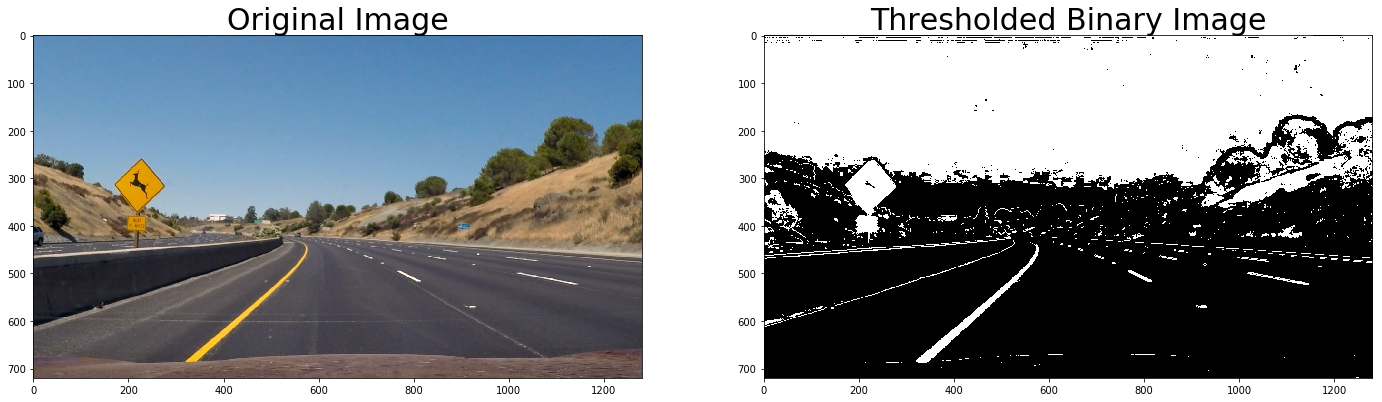

In [9]:
test_image = mpimg.imread('test_images/test2.jpg')

combined = thresholded_binary_image(test_image)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)

plt.imshow(test_image)

plt.title('Original Image', fontsize=30)
plt.subplot(1, 2, 2)
plt.title('Thresholded Binary Image', fontsize=30)
plt.imshow(combined, cmap='gray')

plt.show()

7.SLIDING WINDOW

In [10]:
def zerolistmaker(n):
    listofzeros = [[0,0,0]] * n
    return listofzeros


def find_peaks(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #####################

    # Return x-position of the two peaks
    return leftx_base, rightx_base

left_poly_prev = 0
right_poly_prev = 0
loop_first = True
buffer_length = 2
buffer_left = zerolistmaker(buffer_length)
buffer_right = zerolistmaker(buffer_length)
iteration = 0

def sliding_window(binary_warped, leftx_base, rightx_base,left_poly_prev, right_poly_prev, nwindows=9):
    
    #global  left_poly_prev
    #global right_poly_prev
    global  buffer_left
    global buffer_right
    global iteration

    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
   
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
   
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
   
    ###########################################################################    
    if (loop_first) == True:
        
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #testing
        #print('image1')
        

        
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (_poly_prev[0]*(nonzeroy**2) + left_poly_prev[1]*nonzeroy + left_poly_prev[2] - margin)) & (nonzerox < (left_poly_prev[0]*(nonzeroy**2) + left_poly_prev[1]*nonzeroy + left_poly_prev[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_poly_prev[0]*(nonzeroy**2) + right_poly_prev[1]*nonzeroy + right_poly_prev[2] - margin)) & (nonzerox < (right_poly_prev[0]*(nonzeroy**2) + right_poly_prev[1]*nonzeroy + right_poly_prev[2] + margin)))  
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
     
    return left_fit, right_fit
    

8.DETERMINE CURVATURE

In [11]:
# Calculate the lane line curvature

def measure_curvature(ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
   
    # Define y-value where we want radius of curvature
    # maximum y-value corresponds to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad
 

9.DRAW POLYGON

In [12]:
# Plot the polygons on the image
def draw_polygon(ploty, fitl, fitr, orig):
    pts_left = np.array([np.transpose(np.vstack([fitl, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitr, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    overlay = np.zeros_like(orig).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the original road
    newwarp = transform_perspective(overlay, inverse=True)
    
    # Combine the result with the original image
    result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)
    return result

In [13]:

def car_offset(left_fit, right_fit, img):

    
    xm_per_pix = 3.7/700
    hight = img.shape[0]
    width = img.shape[1]
    
    # compute position of two polynomials
    
    left_pos = left_fit[0]*hight**2+left_fit[1]*hight+left_fit[2]
    right_pos = right_fit[0]*hight**2+right_fit[1]*hight+right_fit[2]
    
    centre_pos=np.mean([left_pos,right_pos])
    # Find the offset from the centre position of two polynomials
    offset_per_pix=(width/2 - centre_pos)
    offset=offset_per_pix*xm_per_pix
    
    return abs(offset)



10.SANITY CHECKER

In [14]:
def similar_curvature(left_curverad, right_curverad):
    '''
    Checking that they are separated by approximately the right distance horizontally
    '''
    #print('sanity checker  curverad', np.abs(left_curverad-right_curverad))
    threshold =1000
    if np.abs(left_curverad-right_curverad) > threshold:
        return False
    return True

def horizontal_distance(left_fit, right_fit, img):
    '''
    Checking that they are separated by approximately the right distance horizontally
    '''
    xm_per_pix = 3.7/700
    hight = img.shape[0]
    width = img.shape[1]
    threshold_max = 4
    threshold_min = 3
    
    left_pos = left_fit[0]*hight**2+left_fit[1]*hight+left_fit[2]
    right_pos = right_fit[0]*hight**2+right_fit[1]*hight+right_fit[2]
    #print('sanity checker distance', abs(left_pos-right_pos)*xm_per_pix)
    
    if (abs(left_pos-right_pos)*xm_per_pix > threshold_max) or abs(left_pos-right_pos)*xm_per_pix < threshold_min:
        return False
    return True

def parallel(left_fit, right_fit):
    '''
    Checking that they are roughly parallel
    '''
    threshold=(0.0005, 0.5)
    for i, j, t in zip(left_fit[:2],right_fit[:2], threshold):
        if np.absolute(i - j) > t:
            return False
    return True

def sanity_checker(left_fit, right_fit, img, left_curverad, right_curverad):
    
 
    if (similar_curvature(left_curverad, right_curverad) and horizontal_distance(left_fit, right_fit, img) and parallel(left_fit, right_fit))==True:
        #print ('sanity OK')
        return True
    else:
        #print ('sanity FAIL')
        return False                                                                                                                             
                                                                                                                                        
                                                                                                                                        
    
    


##############################################
VEHICLE TRACKING

8792
8968
image size (64, 64, 3)


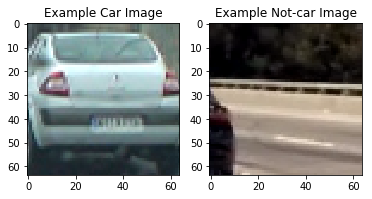

In [15]:
# Read in our vehicles and non-vehicles

cars = []
notcars = []

images_cars = glob.glob('vehicles/*/*.png')
images_notcars = glob.glob('non-vehicles/*/*.png')

for image_car in images_cars:
    cars.append(image_car)

for image_nocar in images_notcars:
    notcars.append(image_nocar)
    

        
print(len(cars))
print(len(notcars))



car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
print('image size',car_image.shape)

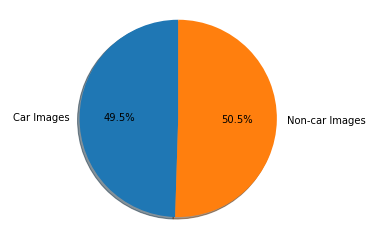

Number of pictures: CAR : 8792
Number of pictures: NON-CAR : 8968
image size (64, 64, 3)


In [16]:
labels = 'Car Images', 'Non-car Images'
sizes = [len(cars), len(notcars)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Number of pictures: CAR :', len(cars))
print('Number of pictures: NON-CAR :', len(notcars))
print('image size',car_image.shape)

FUNCTIONS

In [17]:
# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        #plt.imshow(hog_image)
        #plt.show()
        #print(features)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)

        
        
        
        return features
    
    
# Compute binned color features  size=(32, 32)
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    #print('size', size)
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#CHANGE CHANNEL AS IT WAS
# Compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Extract features from a single image spatial_size=(32, 32)
def extract_single_image_features(image, cspace='YCrCb', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=-1, 
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
        
    # Apply bin_spatial() to get spatial color features
    
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)
        
    # Apply color_hist() also with a color space option now
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(hist_features)
        
    if hog_feat == True:
        if hog_channel == -1: #ALLChannels
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
  
    return np.concatenate(features)


# Extract features from a list of images
def extract_features(imgs, cspace='YCrCb', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=-1, 
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_list = extract_single_image_features(image, cspace=cspace, spatial_size=spatial_size,
                    hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

        # Append the new feature vector to the features list
        features.append(feature_list)
    # Return list of feature vectors
    return features

SVM CLASSIFIER

In [18]:

###PAMETERS
color_space = 'YCrCb' 
orient = 8  
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = -1 
spatial_size = (16, 16) 
hist_bins = 32    
spatial_feat = True 
hist_feat = True 
hog_feat = True 
y_start_stop = [None, None] 


############# DATA FITED TO CALSSIFIER SVM AND NN => HOG FEATURES
car_features = extract_features(cars, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


print('spliting...')
# Split data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


print('DONE...')
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Total training images:', len(X_train))
print('Total test images:', len(X_test))
############## SVM CLASSIFIER####################################################
# SVM IS COMPUTED BUT NOT USED IN PROJECT PREDICTION => APPLIED ONLY AS REFERANCE
#################################################################################
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print('training...')
svc.fit(X_train, y_train)
print('DONE...')

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# ACCURACY FOR THE SVC - TEST DATA
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t=time.time()


spliting...
DONE...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
Total training images: 14208
Total test images: 3552
training...
DONE...
11.75 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


NN CLASSIFIER

Using TensorFlow backend.


Epoch 1/5
14208/14208 [==============================] - ETA: 225s - loss: 0.3548 - acc: 0.4297 - ETA: 119s - loss: 0.3145 - acc: 0.5195 - ETA: 83s - loss: 0.2889 - acc: 0.5651  - ETA: 65s - loss: 0.2469 - acc: 0.6348 - ETA: 54s - loss: 0.2184 - acc: 0.6750 - ETA: 47s - loss: 0.1989 - acc: 0.7044 - ETA: 42s - loss: 0.1803 - acc: 0.7333 - ETA: 38s - loss: 0.1705 - acc: 0.7480

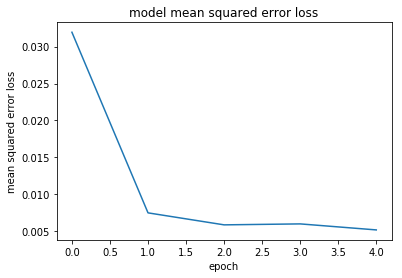

In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *

learning_rate= 0.0001
MODEL_NAME = 'vehicle_detection-{}-{}.model'.format(learning_rate, '2conv-basic')
# SAME DATA AS FOR SVM USED TO TRAIN NN
x_train = X_train
y_train = y_train
x_test = X_test
y_test = y_test


#DEFINITION OF NN ARCHITECTURE
model = Sequential()
#
model.add(Dense(4096, input_dim=5568, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# FIT THE DATA
model.compile (optimizer = Adam(learning_rate), loss = "mse", metrics=['accuracy'])
history = model.fit(x_train, y_train,
          epochs=5,
          batch_size=128,verbose = 1)
score = model.evaluate(x_test, y_test, batch_size=128)


### plot the loss for each epoch
print(history.history.keys())
print(score)

plt.plot(history.history['loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')

plt.savefig('MSE.png', bbox_inches='tight')

model.save(MODEL_NAME)
print('model saved')
model.summary()

TEST ON IMAGE

In [20]:
image = mpimg.imread('bbox-example-image.jpg')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
#####xy_window=(64, 64)   
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


#####testing


(720, 1280, 3)


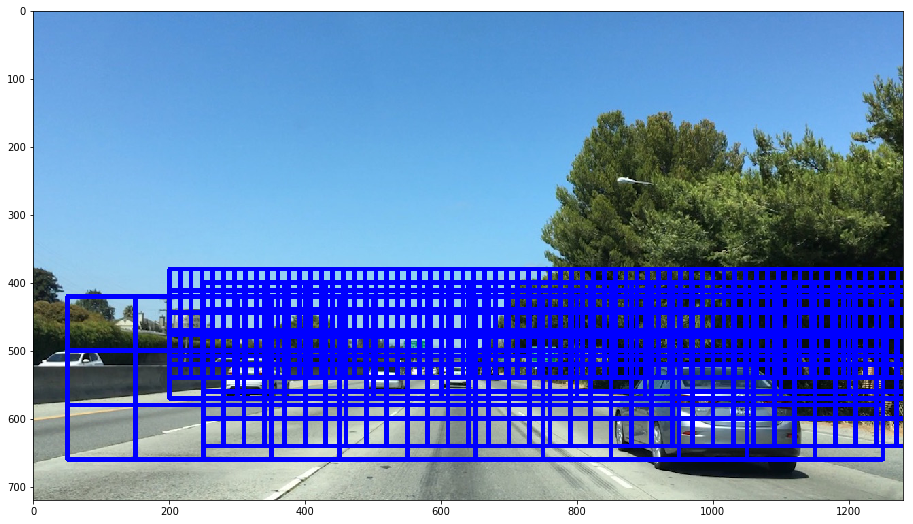

In [21]:
def scanning_windows(image, max_w = 10, inter_1 = 5, inter_2 = 5, min_w=3):
     #DEFINE WINDOWS IN 4 PERSPECTIVES
    scan_windows = []
   
    #PERSPECTIVE MAX
    windows_max = slide_window(image, x_start_stop=[200, None], y_start_stop=[380, 550], \
                         xy_window=(64,64), xy_overlap=(0.75, 0.5))
    for i in range (max_w):

        scan_windows.append(windows_max[i])
                           

    #PERSPECTIVE INTERMEDIATE 1       
    windows_intermediate_1 = slide_window(image, x_start_stop=[250, None], y_start_stop=[400, 700], \
                         xy_window=(120,80), xy_overlap=(0.75, 0.5))
    for i in range (inter_1):

        scan_windows.append(windows_intermediate_1[i])
        
        
    #PERSPECTIVE INTERMEDIATE 2
    windows_intermediate_2 = slide_window(image, x_start_stop=[200, None], y_start_stop=[420, 700], \
                         xy_window=(200,100), xy_overlap=(0.75, 0.5))
    for i in range (inter_2):
 
        scan_windows.append(windows_intermediate_2[i])    
       
    #PERSPECTIVE MIN
    windows_min = slide_window(image, x_start_stop=[50, None], y_start_stop=[420, 700], \
                         xy_window=(200,160), xy_overlap=(0.5, 0.5))
    for i in range (min_w):
    
        scan_windows.append(windows_min[i])

    # RETURN ALL WINDOWS IN 4 PERSPECTIVES     
    return scan_windows


windows = scanning_windows(image, max_w = 264, inter_1 = 164,inter_2 = 40, min_w = 22)

                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=5)  
print(image.shape)
plt.figure(figsize=(24,9))
plt.imshow(window_img)

SLIDING WINDOWS TEST

In [22]:

def search_windows(img, windows, model, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=-1):
    

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #plt.imshow(test_img)
        #print(test_img.shape)
        #4) Extract features for that window using single_img_features()
        features = extract_single_image_features(test_img, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        #####PREDICTION#############
        ############################
        prediction = model.predict(test_features)
 
        if prediction == 1:
            #print (prediction, dec)
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
#remove video
def image_processing(image, test=True):
    # Save a raw image
    draw_image = np.copy(image)
    # Normalize image
    image = image.astype(np.float32)/255
    # Apply pipeline to the image to create black and white image
    hot_windows = search_windows(image, windows, model, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel) 
    

    draw_image = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)
 
 #BEZ SENSU tylko return draw_image, hot_windows
    if not test:
        return draw_image, hot_windows
    else:
        return draw_image


BOUNDING BOXES

In [23]:
image_bboxes = []


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.putText(img, 'CAR', bbox[0], cv2.FONT_HERSHEY_SIMPLEX,  1,(255,255,255),2)       
    # Return the image
    return img
#def heat_map(image, combine_frame_no=0, threshold=2, combine_frame=False):
def heating_map(image, number_frames = 0, threshold=2):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)


    for boxlist in image_bboxes[-number_frames:]: # how many frames taken to common map 
        heat = add_heat(heat, boxlist)
    #else:
        #heat = add_heat(heat, image_bboxes[-1])# -1 last one
        

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap
    


def image_processing_heatmap(image, image_bboxes,frame_no, number_frames = 5, threshold=4): 

    window_img, hot_windows = image_processing(image)
  
    
    image_bboxes.append(hot_windows)
    
    
    draw_img, heat_map = heating_map(image, number_frames = number_frames, threshold=threshold)
    
    return draw_img


                   
   

11.PIPELINE

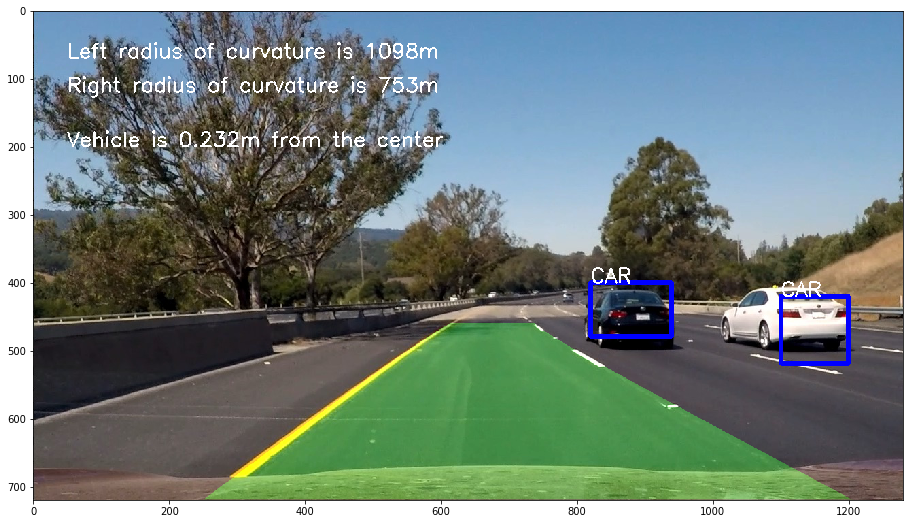

In [27]:

#left_poly_old = None
#right_poly_old = None
image_smooth = False
left_poly_buffer = None
right_poly_buffer = None
left_poly_old = None
right_poly_old = None


def pipeline(img):
    
    #definition of global variables  
    
    global left_poly_old, right_poly_old
    global  left_poly_prev, right_poly_prev
    global loop_first
    global iteration
    global  buffer_left
    global buffer_right
    global image_smooth
    global left_poly_buffer, right_poly_buffer
    global frame
    global image_bboxes
    
    image_tracking = np.copy(img)
    
    # Undistort sample image
    undistorted_image = undistort(img, mtx, dist)
    
    # Apply combine treshold for undistorted image
    combined = thresholded_binary_image(undistorted_image)
    
    # Transform perspective
    mask = transform_perspective(combined)
    
    
    # Compute maximal values of lane peaks in image histogram
    left_peak, right_peak = find_peaks(mask)
    
    # Apply sliding windows and find cofficients of polymonials
    left_poly, right_poly = sliding_window(mask, left_peak, right_peak,left_poly_prev, right_poly_prev)
    left_poly_prev = left_poly
    right_poly_prev = right_poly
    loop_first = True
        
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
    leftx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2]
    rightx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
        
    # Compute te curvature radius
    
    left_curverad, right_curverad = measure_curvature(ploty, leftx, rightx)
    
    #testing
    #print ('curvature left',left_curverad )
    #print ('curvature right',right_curverad )
    #print('distance', left_curverad-right_curverad)
    #print ('right poly',right_poly )
    #print ('left poly',left_poly )
   
    # Get mean of curvatures
    curverad = np.mean([left_curverad, right_curverad])
  
    

        ##########Sanity Checker call#############
    if sanity_checker(left_poly, right_poly, img, left_curverad, right_curverad)==False:
        left_poly = left_poly_old
        right_poly = right_poly_old
        #print('Hallo 1')
        
        ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
        leftx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2]
        rightx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
        
        left_curverad, right_curverad = measure_curvature(ploty, leftx, rightx)
    else: 
        left_poly = left_poly
        right_poly = right_poly
        #print('Hallo 2')
        left_poly_old = left_poly
        right_poly_old = right_poly
    
    ##########BUFFER DEFINITION
    #"""
    buffer_left.append(left_poly)
    del buffer_left[0]

    buffer_right.append(right_poly)
    del buffer_right[0]
        #print('image2')
    
    iteration = iteration + 1
    
    if iteration<2:
        
        if image_smooth == False:
            left_poly = left_poly
            right_poly = right_poly
        else:
            left_poly = left_poly_buffer
            right_poly = right_poly_buffer
            
    else:
        left_poly = np.average(buffer_left, axis=0)
        right_poly = np.average(buffer_right, axis=0)
        left_poly_buffer = left_poly
        right_poly_buffer = right_poly
        iteration = 0
        image_smooth = True
        buffer_left = zerolistmaker(buffer_length)
        buffer_right = zerolistmaker(buffer_length)
    ##########END OF BUFFER
    #"""   
    
    # Draw polygon ogn processed image
    final_image = draw_polygon(ploty, leftx, rightx, img)
    offset = car_offset(left_poly, right_poly, final_image)
        
    # Write tect on processed image

    cv2.putText(final_image, 'Left radius of curvature is {}m'.format(int(left_curverad)), (50, 70), cv2.FONT_HERSHEY_SIMPLEX,  1,(255,255,255),2)
    cv2.putText(final_image, 'Right radius of curvature is {}m'.format(int(right_curverad)), (50, 120), cv2.FONT_HERSHEY_SIMPLEX,  1,(255,255,255),2)

    if offset < 0:
        text = "Vehicle is {:.3f}m left from the center".format(-offset)
    else:
        text = "Vehicle is {:.3f}m from the center".format(offset)
    cv2.putText(final_image, text, (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    xm_per_pix = 3.7/700
    hight = img.shape[0]
    width = img.shape[1]

    left_pos = left_poly[0]*hight**2+left_poly[1]*hight+left_poly[2]
    right_pos = right_poly[0]*hight**2+right_poly[1]*hight+right_poly[2]
    
    #testing
    #print(left_pos)
    #print(right_pos)
    #print('separated',abs(left_pos-right_pos)*xm_per_pix)
    
    #5
    number_frames=10
    threshold=3
    #4
    window_img, hot_windows = image_processing(image_tracking, test=False)
    #scipy.misc.imsave('window_image/frame' + str(frame) + '.jpg', window_img)
    
    image_bboxes.append(hot_windows)
    
   
    final_image_tracking, heat_map = heating_map(image_tracking, number_frames = number_frames, threshold=threshold)
    
    
    # Draw polygon ogn processed image
    final_image = draw_polygon(ploty, leftx, rightx, final_image_tracking)
    offset = car_offset(left_poly, right_poly, final_image)
        
    # Write tect on processed image

    cv2.putText(final_image, 'Left radius of curvature is {}m'.format(int(left_curverad)), (50, 70), cv2.FONT_HERSHEY_SIMPLEX,  1,(255,255,255),2)
    cv2.putText(final_image, 'Right radius of curvature is {}m'.format(int(right_curverad)), (50, 120), cv2.FONT_HERSHEY_SIMPLEX,  1,(255,255,255),2)

    if offset < 0:
        text = "Vehicle is {:.3f}m left from the center".format(-offset)
    else:
        text = "Vehicle is {:.3f}m from the center".format(offset)
    cv2.putText(final_image, text, (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    xm_per_pix = 3.7/700
    hight = img.shape[0]
    width = img.shape[1]

    left_pos = left_poly[0]*hight**2+left_poly[1]*hight+left_poly[2]
    right_pos = right_poly[0]*hight**2+right_poly[1]*hight+right_poly[2]
    
    
    
    
    
    
    
    return final_image

#perform the test on sample image
test_image = mpimg.imread('test_images/test6.jpg')
#test_image = mpimg.imread('bbox-example-image.jpg')

result= pipeline(test_image)

plt.figure(figsize=(24,9))
    
plt.imshow(result)




TEST ON PICTURES

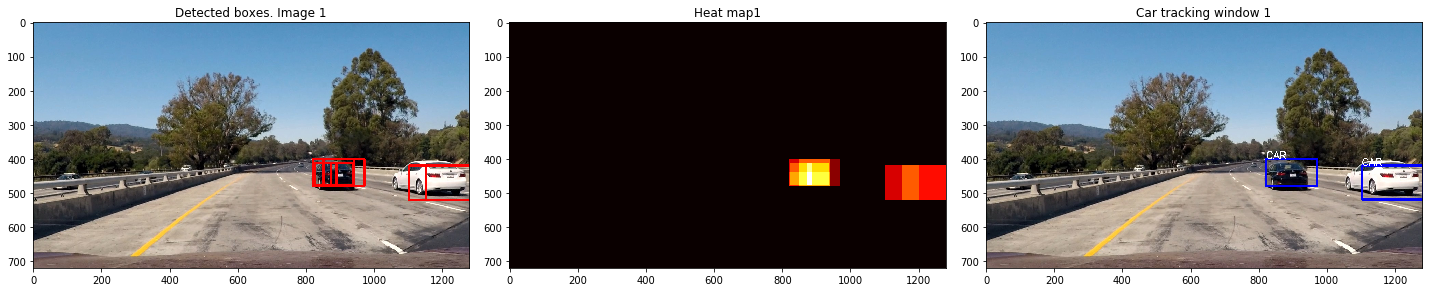

In [31]:
for i in range(1,2):
    image = mpimg.imread('test_images/test{}.jpg'.format(i))
    window_img, hot_windows = image_processing(image, test=False)
    image_bboxes.append(hot_windows)
   
    draw_img, heatmap = heating_map(image, threshold=4)
    fig = plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.imshow(window_img)
    plt.title('Detected boxes. Image ' + str(i))
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    
    plt.title('Heat map' + str(i))
    plt.subplot(133)
    plt.imshow(draw_img)
   
    plt.title('Car tracking window ' + str(i))
    fig.tight_layout()

12.PROCESS LANE DETECTION ON PROJECT VIDEOS

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#video_input = 'project_video.mp4'
#video_output = 'project_video_detected_combined_cnn_11.mp4'

video_input = 'test_video.mp4'
video_output = 'test_video_detected_combined_cnn_10.mp4'


clip2 = VideoFileClip(video_input)
project_clip = clip2.fl_image(pipeline)
%time project_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video test_video_detected_combined_cnn_10.mp4
[MoviePy] Writing video test_video_detected_combined_cnn_10.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:02<00:03,  3.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_detected_combined_cnn_10.mp4 

Wall time: 2min 2s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))